# Juego de la Vida (Game of Life)
El **Juego de la Vida**, también conocido como **Vida**, es un autómata celular diseñador por el matemático británico John Horton Conway en 1970. Es un juego sin jugadores, esto significa que su evolución está determinada por su estado inicial, sin requerir más entradas. Uno interactúa con el Juego de la Vida al crear un estado inicial (o configuración inicial) y se observa como evoluciona. Es Turing completo (puede simular cualquier máquina de Turing) y puede simular un constructor universal o cualquier otra máquina de Turing.
<center>
<img src="https://1.bp.blogspot.com/-pdQ2ckeQzCw/WwGFbYTKRoI/AAAAAAAAAY8/kb-gcutnkKc2TnQainAlYK5FlWmv87XywCPcBGAYYCw/s1600/ezgif.com-video-to-gif.gif" width=250 height=250 />
</center>

## Reglas

El universo (o entorno) del Juego de la Vida es infinito, cuadrícula ortogonal bidimensional de celdas cuadradas, cada una de ellas se encuentra con uno de dos posibles estados, vivo o muerto (o poblado o despoblado, respectivamente). Cada celda interactúa con ocho vecinos, que son las celdas adyacentes horizontales, verticales y diagonales. En cada paso de tiempo, las siguientes transiciones ocurren:

1. Cualquier celda viva con menos de dos vecinos vivos muere, debido a la poca población.
2. Cualquier celda viva con dos o tres vecinos vivos sobrevive para la siguiente generación.
3. Cualquier celda con más de tres vecinos vivos muere, debido a sobre población.
4. Cualquier celda muerta con exactamente tres vecinos vivos se convierte en una celda viva, debido a la reproducción.

Estas reglas, que comparan el comportamiento del autómata a la vida real, pueden ser condensadas en lo siguiente:

1. Cualquier celda viva con dos o más vecinos vivos sobrevive.
2. Cualquier celda muerta con tres vecinos vivos se convierte en una celda viva.
3. Cualquier otra celda viva muere en la siguiente generación. De manera similar, cualquier otra celda muerta se queda muerta.

El patrón inicial constituye la semilla del sistema. La primera generación es creada al aplicar las reglas anteriores de manera simultanea a cualquier celda en la semilla, viva o muerta; nacimientos y muertes ocurren simultáneamente, y el momento discreto en el cual esto pasa es a veces llamado turno. Cada generación es una función pura de la anterior. Las reglas se aplican de forma repetida para crear nuevas generaciones.

## Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar el juego de la vida usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes.

In [1]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# BATCH_RUNNER
from mesa.batchrunner import batch_run

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [2]:
# Definir agente
class RobotCleanerAgent(Agent):

    # Constructor de la clase
    def __init__(self, id, model):
        super().__init__(id, model)
        self.cells_cleaned = 0
        self.cells_visited = 1

    def move(self):
        posible_positions = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)

        # Obtener indices del arreglo de posiciones posibles
        indexes = [x for x in range(len(posible_positions))]
        np.random.shuffle(indexes)

        for index in indexes:
            postion = posible_positions[index]
            if self.model.grid.is_cell_empty(postion):
                self.model.grid.move_agent(self, postion)
                self.cells_visited += 1
                break
    
    def step(self):
        (x, y) = self.pos
        if self.model.cells[x][y] == 1:
            self.model.cells[x][y] = 0
            self.cells_cleaned += 1
        else:
            self.move()

In [3]:
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for content, (x, y) in model.grid.coord_iter():
        grid[x][y] = model.cells[x][y]
        if content != None:
            grid[x][y] = 2
    return grid

In [4]:
# Definir modelo
class RobotCleanerModel(Model):
    
    # Constructor de la clase
    def __init__(self, width, height, dirty_cells = 90, agents = 5):
        super().__init__()
        self.grid = SingleGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            model_reporters = {
                "Grid": get_grid,
                "Steps": lambda model : model.steps,
                "Dirty": lambda model : model.cells.sum() / model.cells.size
                },
            agent_reporters= {
                "Efficiency": lambda a : a.cells_cleaned / a.cells_visited
            }
        )
        self.cells = np.zeros((width, height))

        count = int((width * height) * (dirty_cells / 100))

        while count > 0:
            x = np.random.randint(0, width)
            y = np.random.randint(0, height)
            if self.cells[x][y] == 0:
                self.cells[x][y] = 1
                count -= 1

        self.steps = 0

        for i in range(agents):
            agent = RobotCleanerAgent(i, self)
            self.grid.move_to_empty(agent)
            self.schedule.add(agent)

    def is_all_cells_clean(self):
        return self.cells.sum() == 0
    
    def step(self):
        if not self.is_all_cells_clean():
            self.steps += 1

        self.datacollector.collect(self)
        self.schedule.step()

In [5]:
N = 10
AGENTS = 5
DIRTY_CELLS = 90

model = RobotCleanerModel(N, N, DIRTY_CELLS, AGENTS)
while not model.is_all_cells_clean():
    model.step()

print("Modelo terminado en", model.steps, "pasos")

Modelo terminado en 156 pasos


In [6]:
all_grids = model.datacollector.get_model_vars_dataframe()
all_grids.head()

,Grid,Steps,Dirty
0,"[[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",1,0.90
1,"[[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",2,0.85
2,"[[0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0,...",3,0.85
3,"[[0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0,...",4,0.81
4,"[[0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0,...",5,0.81


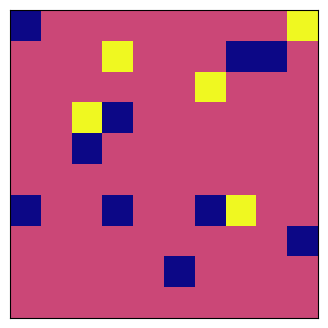

In [7]:
fig, axs = plt.subplots(figsize=(4, 4))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grids.iloc[0,0], cmap=plt.cm.plasma)

def animate(i):
  patch.set_data(all_grids.iloc[i,0])


anim = animation.FuncAnimation(fig, animate, frames=range(len(all_grids)), repeat=False)
anim



In [8]:
params = {
    "width": 20,
    "height": 20,
    "dirty_cells": 90,
    "agents": range(5, 20, 5)
}

STEPS = 100
ITERATIONS = 5

results = batch_run(
    RobotCleanerModel,
    parameters = params,
    iterations = ITERATIONS,
    max_steps = STEPS,
    number_processes = 1,
    data_collection_period=1,
    display_progress=True
)

  0%|          | 0/15 [00:00<?, ?it/s]

In [9]:
df = pd.DataFrame(results)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15150 entries, 0 to 15149
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   RunId        15150 non-null  int64  
 1   iteration    15150 non-null  int64  
 2   Step         15150 non-null  int64  
 3   width        15150 non-null  int64  
 4   height       15150 non-null  int64  
 5   dirty_cells  15150 non-null  int64  
 6   agents       15150 non-null  int64  
 7   Grid         15150 non-null  object 
 8   Steps        15150 non-null  int64  
 9   Dirty        15150 non-null  float64
 10  AgentID      15150 non-null  int64  
 11  Efficiency   15150 non-null  float64
dtypes: float64(2), int64(9), object(1)
memory usage: 1.4+ MB


In [10]:
df.head(10)

,RunId,iteration,Step,width,height,dirty_cells,agents,Grid,Steps,Dirty,AgentID,Efficiency
0,0,0,0,20,20,90,5,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0,...",1,0.9000,0,0.0
1,0,0,0,20,20,90,5,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0,...",1,0.9000,1,0.0
2,0,0,0,20,20,90,5,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0,...",1,0.9000,2,0.0
3,0,0,0,20,20,90,5,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0,...",1,0.9000,3,0.0
4,0,0,0,20,20,90,5,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0,...",1,0.9000,4,0.0
5,0,0,1,20,20,90,5,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0,...",2,0.8875,2,1.0
6,0,0,1,20,20,90,5,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0,...",2,0.8875,4,1.0
7,0,0,1,20,20,90,5,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0,...",2,0.8875,3,1.0
8,0,0,1,20,20,90,5,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0,...",2,0.8875,0,1.0
9,0,0,1,20,20,90,5,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0,...",2,0.8875,1,1.0


In [11]:
new_df = df[(df.Step == STEPS) & (df.AgentID == 4)]
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 502 to 15142
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   RunId        15 non-null     int64  
 1   iteration    15 non-null     int64  
 2   Step         15 non-null     int64  
 3   width        15 non-null     int64  
 4   height       15 non-null     int64  
 5   dirty_cells  15 non-null     int64  
 6   agents       15 non-null     int64  
 7   Grid         15 non-null     object 
 8   Steps        15 non-null     int64  
 9   Dirty        15 non-null     float64
 10  AgentID      15 non-null     int64  
 11  Efficiency   15 non-null     float64
dtypes: float64(2), int64(9), object(1)
memory usage: 1.5+ KB


In [12]:
print("Average percentage of dirty cells: ", new_df['Dirty'].mean())
print("Minimum percentage of dirty cells: ", new_df['Dirty'].min())
print("Maximum percentage of dirty cells: ", new_df['Dirty'].max())

Average percentage of dirty cells:  0.336
Minimum percentage of dirty cells:  0.115
Maximum percentage of dirty cells:  0.575


In [13]:
import seaborn as sns

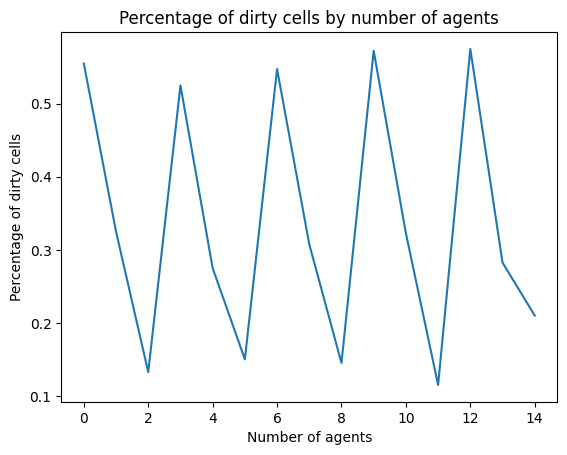

In [14]:
g = sns.lineplot(data=new_df, x='RunId', y='Dirty')
g.set_title("Percentage of dirty cells by number of agents")
g.set_ylabel("Percentage of dirty cells")
g.set_xlabel("Number of agents")

plt.show()